In [6]:
#before using this you need to make a link-breaked version of the roads in yoru database with the osm2pgrourting tool. 
#before use it requires a security setup: (for security reasons it wqill only run on a database which has a password setup):
#$ sudo -u postgres psql
# \password
# (enter 'postgres' for the password twice)
# Ctrl-D (to exit psql)
#Then run the link-breaking with:
#$ osm2pgrouting -f data/dcc.osm -d mydatabasename -W postgres
#you also need to do
# $ psql -d mydatabasename
# CREATE EXTENSION pgrouting
#in psql, to enable postgres routing extension.

##This code has OD rationality plots , but not visualisations

import psycopg2
import pandas as pd
import geopandas as gpd
import pyproj
import os,re,datetime
from matplotlib.pyplot import *
con = psycopg2.connect(database='mydatabasename', user='root')
cur = con.cursor()
wgs84  = pyproj.Proj(init='epsg:4326')  #WGS84
bng    = pyproj.Proj(init='epsg:27700') #british national grid
import pandas.io.sql as psql # To read sql files
%matplotlib inline 
import matplotlib.pyplot as plt
#import random
#from random import randint
print ("import complete")

import complete


In [57]:
##Importing BTsite detection site CSVs and cleaning the repetitive counts, 
##with some exceptions of alternate detections
#like a wrapper
class currentUnique():
    lastN = [] #Empty array
    N = 60 #Timestamp difference set

    def calc(self,id,time): #Function inside class , id = mac id , timestamp = time
        # print "last", self.lastN
        idx = [index for index,item in enumerate(self.lastN) if item[0] == id] 
        # print sum(idx)
        self.lastN.append((id,time))
        if idx:
            # print 'present'
            old_time = self.lastN[idx[0]][1]
            del self.lastN[idx[0]]
            if (time - old_time).seconds < self.N:
                return False
            else:
                return True
        else:
            # print 'not present'
            return True

def importDetections():
    print("importing detections...")
    sql = "DROP TABLE IF EXISTS detection_clean;"
    cur.execute(sql)    
    sql = "CREATE TABLE detection_clean ( id serial, siteID text, mac text, \
    timestamp timestamp );"
    cur.execute(sql)    
    dir_detections = "/headless/data/dcc/bluetooth/"
    for fn in sorted(os.listdir(dir_detections)):  #importing all BT sensor files
        print("processing file: " +fn)
        m = re.match("vdFeb14_(.+).csv", fn)  #extracting CSVs matching the file names
        if m is None:  #if there was no regex match then continue
            continue   
        siteID = m.groups()[0]
        fn_detections = dir_detections+fn
        #dataframe.header is which row to use for field names-fn
        df_detections = pd.read_csv(fn_detections, header=0)
        #prev_ts = "" #empty string for timestamp
        #prev_mac = ""#empty string for mac
        cu = currentUnique() #new class
        for i in range(0, df_detections.shape[0]): 
            #here we use Python's DateTime library to store times properly
            datetime_text = df_detections.iloc[i]['Unnamed: 0']
            #proper Python datetime  
            dt = datetime.datetime.strptime(datetime_text, "%d/%m/%Y %H:%M:%S") 
            cur_mac = df_detections.iloc[i]['Number Plate']
            newDetection = cu.calc(cur_mac, dt)
            if not newDetection:
                continue
            sql = "INSERT INTO detection_clean (siteID, timestamp, mac) VALUES ('%s', '%s', '%s');"\
            %(siteID, dt, df_detections.iloc[i]['Number Plate'])
            cur.execute(sql)
            #print(siteID, dt, df_detections.iloc[i]['Number Plate'])
        
        table = psql.read_sql("SELECT * FROM detection_clean", con)
        # print(table)
        print ("Length of  table: ", len(table), df_detections.shape[0])
    con.commit()
    
    print("Cleaning done")
    
importDetections()



importing detections...
processing file: vdFeb14_MAC000010100.csv
Length of  table:  2332 4521
processing file: vdFeb14_MAC000010101.csv
Length of  table:  5403 5946
processing file: vdFeb14_MAC000010102.csv
Length of  table:  8317 5598
processing file: vdFeb14_MAC000010103.csv
Length of  table:  8384 87
processing file: vdFeb14_MAC000010104.csv
Length of  table:  13247 9356
processing file: vdFeb14_MAC000010105.csv
Length of  table:  15647 4763
processing file: vdFeb14_MAC000010106.csv
Length of  table:  18409 5634
processing file: vdFeb14_MAC000010107.csv
Length of  table:  21247 5664
processing file: vdFeb14_MAC000010108.csv
Length of  table:  26856 10728
processing file: vdFeb14_MAC000010109.csv
Length of  table:  31536 9882
processing file: vdFeb14_MAC000010110.csv
Length of  table:  34044 5256
processing file: vdFeb14_MAC000010111.csv
Length of  table:  36878 5398
processing file: vdFeb14_MAC000010112.csv
Length of  table:  40541 7169
processing file: vdFeb14_MAC000010113.csv
Len

In [18]:

def createTotalRoute(con,cur):
    sql = "DROP TABLE IF EXISTS TotalRoute;"
    cur.execute(sql)          
    sql="CREATE TABLE TotalRoute( \
        emp_no SERIAL PRIMARY KEY, \
        ODrouteID text, \
        timestamp timestamp, \
        winlenseconds integer, \
        count integer, OriginSiteID text,\
        DestSiteID text);"
    cur.execute(sql)          
    con.commit() 

createTotalRoute(con,cur)

def makeTotalRoutes(con,cur):
    print("define Total measureable route from origin sensor to destination sensor")

    ODRoutes = {"MeasureableRouteID":["MAC000010119>MAC000010130",\
                                     "MAC000010102>MAC000010104",\
                                     "MAC000010121>MAC000010124",\
                                     "MAC000010101>MAC000010119",\
                                     "MAC000010123>MAC000010120"],\
               "OriginSiteID":["MAC000010119","MAC000010102",\
                               "MAC000010121",\
                               "MAC000010101","MAC000010123"],

                "DestSiteID":["MAC000010130","MAC000010104",\
                              "MAC000010124",\
                              "MAC000010119","MAC000010120"]}
    df=pd.DataFrame.from_dict(ODRoutes)
    for i in range(0,df.shape[0]):    #each route
        routeID = df['MeasureableRouteID'][i]
        oSiteID = df['OriginSiteID'][i]
        dSiteID = df['DestSiteID'][i]
        #MAC matching
        sql = "SELECT d.siteID AS dSiteID,  d.mac as dmac, d.timestamp as dtimestamp,\
        o.siteID AS oSiteID,  o.mac as omac, o.timestamp as otimestamp  \
        FROM detection_clean AS d,detection_clean AS o  \
        WHERE d.timestamp>o.timestamp\
        AND o.mac=d.mac  AND o.siteID='%s'\
        AND d.siteID='%s'"%(oSiteID, dSiteID)

        df_matches = pd.read_sql_query(sql,con)
        count = df_matches.shape[0]  #count number of bluetooth matches
        #these two variables allow us to compute flows for differnt time windows. Here we just take one whole day.
        winlenseconds = 99999999.9
        timestamp = "2015-02-14 09:00:00"
        sql = "INSERT INTO TotalRoute (ODrouteID, timestamp, winlenseconds, count,\
        OriginSiteID, DestSiteID)\
        VALUES ('%s', '%s', %f, %i,'%s','%s')"%(routeID,timestamp,\
        winlenseconds, count, oSiteID, dSiteID)
        cur.execute(sql)
        
    con.commit()  
    print ("Total routes created")
makeTotalRoutes(con,cur)


def createODRoute(con,cur):
    sql = "DROP TABLE IF EXISTS ODRoute;"
    cur.execute(sql)          
    sql="CREATE TABLE ODRoute ( \
            emp_no SERIAL PRIMARY KEY, \
            ODrouteID text, \
            timestamp timestamp, \
            winlenseconds integer, \
            count integer, OriginSiteID text, MidSiteID text, \
            DestSiteID text);"
    cur.execute(sql)          
    con.commit() 

createODRoute(con,cur)

def makeODRoutes(con,cur):
    print("define OD measureable route from each sensor to each other")
    #sql = "SELECT * FROM MeasureableRoute;"
    #df_ODRoutes = pd.read_sql_query(sql,con)
    Routes = {"MeasureableRouteID":["MAC000010119>MAC000010104>MAC000010130",\
                                     "MAC000010119>MAC000010109>MAC000010130",\
                                     "MAC000010102>MAC000010119>MAC000010104",\
                                     "MAC000010102>MAC000010118>MAC000010104",\
                                     "MAC000010121>MAC000010113>MAC000010124",\
                                     "MAC000010121>MAC000010112>MAC000010124",\
                                     "MAC000010101>MAC000010104>MAC000010119",\
                                     "MAC000010101>MAC000010118>MAC000010119",\
                                     "MAC000010123>MAC000010114>MAC000010120",\
                                     "MAC000010123>MAC000010112>MAC000010120"],\
               "OriginSiteID":["MAC000010119","MAC000010119","MAC000010102",\
                               "MAC000010102","MAC000010121","MAC000010121",\
                               "MAC000010101","MAC000010101","MAC000010123",\
                               "MAC000010123"],
                "MidSiteID": ["MAC000010104","MAC000010109","MAC000010119",\
                              "MAC000010118","MAC000010113","MAC000010112",\
                              "MAC000010104","MAC000010118","MAC000010114",\
                              "MAC000010112"],
                "DestSiteID":["MAC000010130","MAC000010130","MAC000010104",\
                              "MAC000010104","MAC000010124","MAC000010124",\
                              "MAC000010119","MAC000010119","MAC000010120",\
                              "MAC000010120"]}
    df=pd.DataFrame.from_dict(Routes)
    #print(df.shape)
    #print(df.shape[0])
    #print("asdf")
# or enter for i in range(0,df.shape[0])    
    for i in range(0,df.shape[0]):    #each route
        routeID = df['MeasureableRouteID'][i]
        oSiteID = df['OriginSiteID'][i]
        mSiteID = df['MidSiteID'][i]
        dSiteID = df['DestSiteID'][i]
        #MAC matching
        sql = "SELECT d.siteID AS dSiteID,  d.mac as dmac, d.timestamp as dtimestamp  ,\
        m.siteID AS mSiteID,  m.mac as mmac, m.timestamp as mtimestamp ,\
        o.siteID AS oSiteID,  o.mac as omac, o.timestamp as otimestamp  \
        FROM detection_clean AS d,detection_clean AS m, detection_clean AS o  \
        WHERE d.timestamp>m.timestamp AND m.timestamp>o.timestamp\
        AND o.mac=m.mac AND m.mac=d.mac  AND d.mac = o.mac AND o.siteID='%s'AND m.siteID='%s'\
        AND d.siteID='%s'"%(oSiteID, mSiteID, dSiteID)
        #print(sql)
        df_matches = pd.read_sql_query(sql,con)
        count = df_matches.shape[0]  #count number of bluetooth matches
        #these two variables allow us to compute flows for differnt time windows. Here we just take one whole day.
        winlenseconds = 99999999.9
        timestamp = "2015-02-14 09:00:00"
        sql = "INSERT INTO ODRoute (ODrouteID, timestamp, winlenseconds, count,\
        OriginSiteID, MidSiteID, DestSiteID)\
        VALUES ('%s', '%s', %f, %i,'%s','%s','%s')"%(routeID,timestamp,\
        winlenseconds, count, oSiteID, mSiteID, dSiteID)
        cur.execute(sql)
        
    con.commit()  
    print ("OD routes created")
makeODRoutes(con,cur)


define Total measureable route from origin sensor to destination sensor
Total routes created
define OD measureable route from each sensor to each other
OD routes created


In [19]:


def createSensorDistances(con,cur):
    sql = "DROP TABLE IF EXISTS SensorDistances;"
    cur.execute(sql)          
    sql = "CREATE TABLE SensorDistances ( \
            emp_no SERIAL PRIMARY KEY, \
            ODRouteID text, gid_link text, \
            om_length integer, md_length integer,\
            total_length integer\
            );"
    cur.execute(sql) 
    sql = "DROP TABLE IF EXISTS ShortestRoute;"
    cur.execute(sql)        
    sql = "CREATE TABLE ShortestRoute ( \
            emp_no SERIAL PRIMARY KEY, \
            ODrouteID text, \
            om_length integer, \
            md_length integer, \
            total_length integer \
            );"
    cur.execute(sql)      
createSensorDistances(con,cur)

def SensorDistances(con,cur):
    print ("computing lengths ..")
    sql = "SELECT ODRouteID OriginSiteID, MidSiteID, \
            DestSiteID from ODRoute"
    sql = "SELECT ODRouteID, OriginSiteID, MidSiteID, \
            DestSiteID, ST_X(orig.geom) AS ox, ST_Y(orig.geom) \
            AS oy, ST_X(mid.geom) AS mx, ST_Y(mid.geom) AS my, ST_X(dest.geom) AS dx,\
            ST_Y(dest.geom) AS dy from ODRoute, \
            BluetoothSite AS orig, BluetoothSite AS mid, BluetoothSite AS dest \
            WHERE OriginSiteID=orig.siteID AND MidSiteID=mid.siteID AND \
            DestSiteID=dest.siteID;"
    #Read bulk of db in psql and enter into DF
    df_dist = pd.read_sql_query(sql,con)
    print (df_dist)
    N = df_dist.shape[:]   
    #N = len(df_dist)
    print (N, "shape of DF")
# for i in range(0, df_dist) or  i in range (10,7) - Error fixed
    for i in range (0, df_dist.shape[0]): 
        OMDrouteID = df_dist['odrouteid'][i]
        origsiteID = df_dist['originsiteid'][i]
        midsiteID  = df_dist['midsiteid'][i]
        destsiteID = df_dist['destsiteid'][i]
   # for i in range(df_dist)
        o_easting  = df_dist['ox'][i]#link-broken table is stored as latlon so convert on the fly
        #print (o_easting)
        #print(df_dist['ox'][i])
        #print(df_dist['ox'])
        o_northing = df_dist['oy'][i]
        m_easting  = df_dist['mx'][i]
        m_northing = df_dist['my'][i]
        d_easting  = df_dist['dx'][i]
        d_northing = df_dist['dy'][i]
        #print(type(o_easting))
        (o_lon,o_lat) = pyproj.transform(bng, wgs84, o_easting, o_northing) #project uses nonISO lonlat convention
        (m_lon,m_lat) = pyproj.transform(bng, wgs84, m_easting, m_northing)
        (d_lon,d_lat) = pyproj.transform(bng, wgs84, d_easting, d_northing) #project uses nonISO lonlat convention 

    #Origin gid
        sql = "SELECT id,ST_Distance(ways_vertices_pgr.the_geom,\
        ST_SetSRID(ST_MakePoint(%f, %f),4326)) FROM ways_vertices_pgr \
        ORDER BY st_distance ASC LIMIT 1;"%(o_lon,o_lat)    #4326=SRID code for WGS84
        df_on = pd.read_sql_query(sql,con)
        o_vertex_gid = df_on['id'][0] #get the vertexID of its source
        print ("Origin GIDs selected")
    #Mid gid
        sql = "SELECT id,ST_Distance(ways_vertices_pgr.the_geom,\
        ST_SetSRID(ST_MakePoint(%f, %f),4326)) FROM ways_vertices_pgr \
        ORDER BY st_distance ASC LIMIT 1;"%(m_lon,m_lat)    #4326=SRID code for WGS84
        df_mn = pd.read_sql_query(sql,con)
        m_vertex_gid = df_mn['id'][0] #get the vertexID of its source
        print ("Mid GIDs selected")
    
    #Dest gid
        sql = "SELECT id,ST_Distance(ways_vertices_pgr.the_geom,\
        ST_SetSRID(ST_MakePoint(%f, %f),4326)) FROM ways_vertices_pgr \
        ORDER BY st_distance ASC LIMIT 1;"%(d_lon,d_lat)    #4326=SRID code for WGS84
        df_dn = pd.read_sql_query(sql,con)
        d_vertex_gid = df_dn['id'][0] #get the vertexID of its source
        print ("Dest GIDs selected")
        
        #pgr_dijkstra(o_vertex_gid, m_vertex_gid)
        sql = "SELECT * FROM pgr_dijkstra('SELECT gid AS id, source, target, \
        length_m AS cost FROM ways', %d,%d, directed := false), \
        ways  WHERE ways.gid=pgr_dijkstra.edge;"%(o_vertex_gid, m_vertex_gid)
        print ("Shortest path between origin and mid sensors found")
        df_route_1 = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='the_geom')
        OM_route   = pd.read_sql_query(sql,con)

        #pgr_dijkstra(m_vertex_gid, d_vertex_gid)        
        sql = "SELECT * FROM pgr_dijkstra('SELECT gid AS id, source, target, \
        length_m AS cost FROM ways', %d,%d, directed := false), \
        ways  WHERE ways.gid=pgr_dijkstra.edge;"%(m_vertex_gid, d_vertex_gid)
        print ("Shortest path between mid and destination sensors found")
        df_route_2 = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='the_geom')
        MD_route   = pd.read_sql_query(sql,con)

        for i in range(0,df_route_1.shape[0]):
            rc = df_route_1.iloc[i]  #route component
            sql = "INSERT INTO SensorDistances(ODrouteID, gid_link, om_length) \
                VALUES ('%s', %i, %i);" %(OMDrouteID, rc['gid'],rc['length_m'])
                #print(sql)
            cur.execute(sql)
        for i in range(0,df_route_2.shape[0]):
            rc = df_route_2.iloc[i]  #route component
            sql = "INSERT INTO SensorDistances(ODrouteID, gid_link, md_length) \
                VALUES ('%s', %i, %i);" %(OMDrouteID, rc['gid'],rc['length_m'])
                #print(sql)
            cur.execute(sql)
    sql_om = "SELECT distinct odrouteid, sum(om_length) as om from sensordistances\
    group by odrouteid;"
    df_om = pd.read_sql_query(sql_om,con)

    sql_md = "SELECT distinct odrouteid, sum(md_length) as md from sensordistances\
    group by odrouteid;"
    df_md = pd.read_sql_query(sql_md,con)

    #Length tables
    print (df_md.shape[0])
    for i in range(0,df_md.shape[0]):
        rl_md = df_md.iloc[i]  
        rl_om = df_om.iloc[i]  

        sql = "INSERT INTO ShortestRoute(ODrouteID, om_length, md_length, total_length) \
        VALUES ('%s', %i, %i, %i);" %(rl_om['odrouteid'], rl_om['om'],rl_md['md'], rl_om['om']+rl_md['md'])
        print(sql)
        cur.execute(sql)            
    con.commit()
    print ('Sensor to sensor distances calculated' )
       
SensorDistances(con,cur)




computing lengths ..
                                odrouteid  originsiteid     midsiteid  \
0  MAC000010102>MAC000010118>MAC000010104  MAC000010102  MAC000010118   
1  MAC000010102>MAC000010119>MAC000010104  MAC000010102  MAC000010119   
2  MAC000010101>MAC000010104>MAC000010119  MAC000010101  MAC000010104   
3  MAC000010101>MAC000010118>MAC000010119  MAC000010101  MAC000010118   
4  MAC000010123>MAC000010112>MAC000010120  MAC000010123  MAC000010112   
5  MAC000010123>MAC000010114>MAC000010120  MAC000010123  MAC000010114   
6  MAC000010121>MAC000010113>MAC000010124  MAC000010121  MAC000010113   
7  MAC000010121>MAC000010112>MAC000010124  MAC000010121  MAC000010112   
8  MAC000010119>MAC000010109>MAC000010130  MAC000010119  MAC000010109   
9  MAC000010119>MAC000010104>MAC000010130  MAC000010119  MAC000010104   

     destsiteid        ox        oy        mx        my        dx        dy  
0  MAC000010104  435621.0  370547.0  436617.0  370741.0  438388.0  369743.0  
1  MAC000010104  43

In [12]:
def createTotalRouteCount(con, cur):
    sql = "DROP TABLE IF EXISTS Totalroutecount;"
    cur.execute(sql)          
    sql="CREATE TABLE Totalroutecount ( \
            emp_no SERIAL PRIMARY KEY, \
            ODrouteID text, Origin text, Destination text,\
            timestamp timestamp, \
            winlenseconds integer, \
            count integer\
            );"
    cur.execute(sql)          
    con.commit()
createTotalRouteCount(con, cur)

def TotalrouteCounts(con,cur):   #count number of matching Bluetooth detections between origins and destinations
    sql = "SELECT * FROM TotalRoute;"
    df_odroute = pd.read_sql_query(sql,con)
    print (df_odroute)
    for i in range(0, df_odroute.shape[0]):    #each route
        oSiteID = df_odroute['originsiteid'][i]
        #mSiteID = df_odroute['midsiteid'][i]
        dSiteID = df_odroute['destsiteid'][i]
        #MAC matching
        sql = "SELECT d.siteID AS dSiteID,  d.mac as dmac, \
        d.timestamp as dtimestamp, o.siteID AS oSiteID,  \
        o.mac as omac, o.timestamp as otimestamp    \
        FROM Detection_clean AS d, Detection_clean AS o  \
        WHERE d.timestamp>o.timestamp AND d.timestamp-o.timestamp<interval'60 minutes' \
        AND o.mac=d.mac AND o.siteID='%s'\
        AND d.siteID='%s';"%(oSiteID, dSiteID)
        print(sql)
        df_matches = pd.read_sql_query(sql,con)
        count = df_matches.shape[0]  #count number of bluetooth matches
        #these two variables allow us to compute flows for differnt time windows. Here we just take one whole day.
        winlenseconds = 99999999.9
        timestamp = "2015-02-14 09:00:00"
        sql = "INSERT INTO TotalRouteCount (ODrouteID, Origin, Destination, timestamp,\
        winlenseconds, count) VALUES ('%s', '%s', '%s', '%s', %f, %i)"\
        %(df_odroute['odrouteid'].iloc[i],df_odroute['originsiteid'].iloc[i],df_odroute['destsiteid'].iloc[i], \
          df_odroute['timestamp'].iloc[i],\
          winlenseconds, count)
        cur.execute(sql)
        print (sql)
        con.commit()
TotalrouteCounts(con,cur)


def createODRouteCount(con, cur):
    sql = "DROP TABLE IF EXISTS ODroutecount;"
    cur.execute(sql)          
    sql="CREATE TABLE ODroutecount ( \
            emp_no SERIAL PRIMARY KEY, \
            ODrouteID text, Origin text, Destination text, Mid text, \
            timestamp timestamp, \
            winlenseconds integer, \
            count integer \
            );"
    cur.execute(sql)          
    con.commit()
createODRouteCount(con, cur)

def ODrouteCounts(con,cur):   #count number of matching Bluetooth detections between origins and destinations
    sql = "SELECT * FROM ODRoute;"
    df_odroute = pd.read_sql_query(sql,con)
    print (df_odroute)
    for i in range(0, df_odroute.shape[0]):    #each route
        oSiteID = df_odroute['originsiteid'][i]
        mSiteID = df_odroute['midsiteid'][i]
        dSiteID = df_odroute['destsiteid'][i]
        #MAC matching
        sql = "SELECT d.siteID AS dSiteID,  d.mac as dmac, \
        d.timestamp as dtimestamp  , m.siteID AS mSiteID,  m.mac as mmac, \
        m.timestamp as mtimestamp,  o.siteID AS oSiteID,  \
        o.mac as omac, o.timestamp as otimestamp    \
        FROM Detection_clean AS d, Detection_clean AS m, Detection_clean AS o  \
        WHERE d.timestamp>m.timestamp AND m.timestamp>o.timestamp AND d.timestamp>o.timestamp\
        AND d.timestamp-m.timestamp<interval'30 minutes' AND m.timestamp-o.timestamp<interval '30minutes' AND\
        o.mac=m.mac AND m.mac=d.mac AND d.mac=m.mac AND o.siteID='%s'\
        AND m.siteID = '%s' AND d.siteID='%s';" %(oSiteID, mSiteID, dSiteID)
        print(sql)
        df_matches = pd.read_sql_query(sql,con)
        #print(df_matches)
        count = df_matches.shape[0]  #count number of bluetooth matches
        #these two variables allow us to compute flows for differnt time windows. Here we just take one whole day.
        winlenseconds = 99999999.9
        timestamp = "2015-02-14 09:00:00"
        sql = "INSERT INTO ODRouteCount (ODrouteID, Origin, Destination, Mid, timestamp,\
        winlenseconds, count) VALUES ('%s', '%s','%s','%s','%s', %f, %i);"\
        %(df_odroute['odrouteid'].iloc[i], df_odroute['originsiteid'].iloc[i],\
          df_odroute['destsiteid'].iloc[i], df_odroute['midsiteid'].iloc[i],\
          df_odroute['timestamp'].iloc[i], winlenseconds, count)
        cur.execute(sql)
        print (sql)
        con.commit()
ODrouteCounts(con,cur)


   emp_no                  odrouteid           timestamp  winlenseconds  \
0       1  MAC000010119>MAC000010130 2015-02-14 09:00:00      100000000   
1       2  MAC000010102>MAC000010104 2015-02-14 09:00:00      100000000   
2       3  MAC000010121>MAC000010124 2015-02-14 09:00:00      100000000   
3       4  MAC000010101>MAC000010119 2015-02-14 09:00:00      100000000   
4       5  MAC000010123>MAC000010120 2015-02-14 09:00:00      100000000   

   count  originsiteid    destsiteid  
0   1077  MAC000010119  MAC000010130  
1    509  MAC000010102  MAC000010104  
2      4  MAC000010121  MAC000010124  
3    309  MAC000010101  MAC000010119  
4     39  MAC000010123  MAC000010120  
SELECT d.siteID AS dSiteID,  d.mac as dmac,         d.timestamp as dtimestamp, o.siteID AS oSiteID,          o.mac as omac, o.timestamp as otimestamp            FROM Detection_clean AS d, Detection_clean AS o          WHERE d.timestamp>o.timestamp AND d.timestamp-o.timestamp<interval'60 minutes'         AND o.mac=

INSERT INTO ODRouteCount (ODrouteID, Origin, Destination, Mid, timestamp,        winlenseconds, count) VALUES ('MAC000010102>MAC000010118>MAC000010104', 'MAC000010102','MAC000010104','MAC000010118','2015-02-14 09:00:00', 99999999.900000, 59);
SELECT d.siteID AS dSiteID,  d.mac as dmac,         d.timestamp as dtimestamp  , m.siteID AS mSiteID,  m.mac as mmac,         m.timestamp as mtimestamp,  o.siteID AS oSiteID,          o.mac as omac, o.timestamp as otimestamp            FROM Detection_clean AS d, Detection_clean AS m, Detection_clean AS o          WHERE d.timestamp>m.timestamp AND m.timestamp>o.timestamp AND d.timestamp>o.timestamp        AND d.timestamp-m.timestamp<interval'30 minutes' AND m.timestamp-o.timestamp<interval '30minutes' AND        o.mac=m.mac AND m.mac=d.mac AND d.mac=m.mac AND o.siteID='MAC000010121'        AND m.siteID = 'MAC000010113' AND d.siteID='MAC000010124';
INSERT INTO ODRouteCount (ODrouteID, Origin, Destination, Mid, timestamp,        winlenseconds, count)

In [13]:
def createODLinkCount(con, cur):
    sql = "DROP TABLE IF EXISTS ODlinkcount;"
    cur.execute(sql)          
    sql="CREATE TABLE ODlinkcount ( \
            emp_no SERIAL PRIMARY KEY, \
            gid text, \
            timestamp timestamp, \
            winlenseconds integer, \
            count integer \
            );"
    cur.execute(sql)          
    con.commit()
createODLinkCount(con, cur)

def ODlinkCounts(con, cur):
    sql = "SELECT * FROM ODRouteCount;"
    df_rc = pd.read_sql_query(sql,con)
    for i in range(0, df_rc.shape[0]):    #each routecount
        row  = df_rc.iloc[i]
        count         = row['count']
        winlenseconds = row['winlenseconds']
        timestamp     = row['timestamp']
        if count>0:
            sql = "SELECT * FROM SensorDistances WHERE ODrouteid='%s'"%row['odrouteid']
            df_rl = pd.read_sql_query(sql,con)
            for j in range(0, df_rl.shape[0]): #add counts for each link
                link = df_rl.iloc[j]                   #route component
                gid_link = link['gid_link']
                sql = "INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,\
                count) VALUES ('%s','%s', %i, %i);"%(gid_link, \
                timestamp, winlenseconds, count)
                print(sql)
                cur.execute(sql)
            con.commit()
ODlinkCounts(con, cur)


INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8287','2015-02-14 09:00:00', 100000000, 294);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8493','2015-02-14 09:00:00', 100000000, 294);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8494','2015-02-14 09:00:00', 100000000, 294);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8495','2015-02-14 09:00:00', 100000000, 294);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8496','2015-02-14 09:00:00', 100000000, 294);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8497','2015-02-14 09:00:00', 100000000, 294);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('14076','2015-02-14 09:00:00', 100000000, 294);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,             

INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('201','2015-02-14 09:00:00', 100000000, 59);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('202','2015-02-14 09:00:00', 100000000, 59);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('203','2015-02-14 09:00:00', 100000000, 59);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8666','2015-02-14 09:00:00', 100000000, 59);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8694','2015-02-14 09:00:00', 100000000, 59);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8695','2015-02-14 09:00:00', 100000000, 59);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8696','2015-02-14 09:00:00', 100000000, 59);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) V

INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('2655','2015-02-14 09:00:00', 100000000, 18);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('2656','2015-02-14 09:00:00', 100000000, 18);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('3003','2015-02-14 09:00:00', 100000000, 18);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('3004','2015-02-14 09:00:00', 100000000, 18);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('4845','2015-02-14 09:00:00', 100000000, 18);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('4846','2015-02-14 09:00:00', 100000000, 18);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('4847','2015-02-14 09:00:00', 100000000, 18);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count

INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('6984','2015-02-14 09:00:00', 100000000, 3);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8341','2015-02-14 09:00:00', 100000000, 3);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8342','2015-02-14 09:00:00', 100000000, 3);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('8867','2015-02-14 09:00:00', 100000000, 3);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('9177','2015-02-14 09:00:00', 100000000, 3);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('10388','2015-02-14 09:00:00', 100000000, 3);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('11949','2015-02-14 09:00:00', 100000000, 3);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VAL

INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('14611','2015-02-14 09:00:00', 100000000, 3);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('14615','2015-02-14 09:00:00', 100000000, 3);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('14616','2015-02-14 09:00:00', 100000000, 3);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('14617','2015-02-14 09:00:00', 100000000, 3);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('117','2015-02-14 09:00:00', 100000000, 12);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('118','2015-02-14 09:00:00', 100000000, 12);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) VALUES ('119','2015-02-14 09:00:00', 100000000, 12);
INSERT INTO ODlinkcount (gid, timestamp, winlenseconds,                count) V

SELECT odrouteid, count FROM odroutecount;
Flows Vs OD plotted


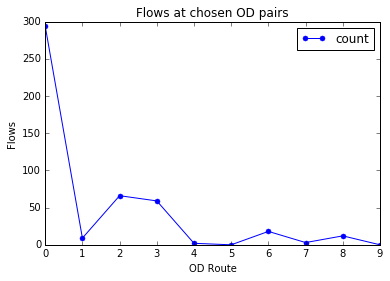

In [14]:
#plot of Flows vs route id
%matplotlib inline 
import matplotlib.pyplot as plt
def plotFlowsvsOD(con,cur):     
    sql = "SELECT odrouteid, count FROM odroutecount;" 
    print(sql)
    fig, ax = subplots()
    df = pd.read_sql_query(sql,con)
    df.plot(ax=ax, marker =".", markersize =10, title = "Flows at chosen OD pairs")
    ax.legend(["count"])
    ax.set_xlabel("OD Route")
    ax.set_ylabel("Flows")

plotFlowsvsOD(con,cur)
print ("Flows Vs OD plotted")



10
4208 18
5133 3
2313 59
3188 66
3808 294
3879 9
2903 0
2673 2
4934 0
4331 12


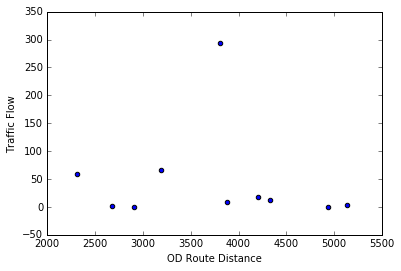

Flows Vs OD Distances plotted


In [15]:
#plot of Flows vs od distances
%matplotlib inline 
import matplotlib.pyplot as plt
def plotFlowsvsODdist(con,cur):     
    sql_count = "SELECT odrouteid, count FROM odroutecount order by odrouteid;"
    sql_id = "SELECT odrouteid, total_length \
    from shortestroute order by odrouteid;" 
    df = pd.read_sql_query(sql_count,con)
    df_new = pd.read_sql_query(sql_id,con)

    #print (df)
    #print(df_new)
    #sql = "SELECT distinct odrouteid, total_length from shortestroute order by odrouteid;"
    #df_new = pd.read_sql_query(sql,con)
    #print (df_new)
    fig = plt.figure()
    print(df.shape[0])
    #print(df)
    for i in range(0,df.shape[0]): 
        print(df_new.iloc[i]['total_length'],df.iloc[i]['count'])   
        plt.scatter(df_new.iloc[i]['total_length'],df.iloc[i]['count'])
        plt.plot(marker =".", markersize =10)
        plt.title = ("Flows at chosen OD pairs")
        plt.xlabel("OD Route Distance")
        plt.ylabel("Traffic Flow")
    plt.show()

plotFlowsvsODdist(con,cur)
print ("Flows Vs OD Distances plotted")

              o             d  flow
0  MAC000010119  MAC000010130   431
1  MAC000010102  MAC000010104   166
2  MAC000010121  MAC000010124     2
3  MAC000010101  MAC000010119    74
4  MAC000010123  MAC000010120    13
             om            dm  flow_m
0  MAC000010119  MAC000010130     294
1  MAC000010119  MAC000010130       9
2  MAC000010102  MAC000010104      66
3  MAC000010102  MAC000010104      59
4  MAC000010121  MAC000010124       2
5  MAC000010121  MAC000010124       0
6  MAC000010101  MAC000010119      18
7  MAC000010101  MAC000010119       3
8  MAC000010123  MAC000010120      12
9  MAC000010123  MAC000010120       0
             om  flow_m
0  MAC000010101      21
1  MAC000010102     125
2  MAC000010119     303
3  MAC000010121       2
4  MAC000010123      12
              o             d  flow            om  flow_m
0  MAC000010119  MAC000010130   431  MAC000010119     303
1  MAC000010102  MAC000010104   166  MAC000010102     125
2  MAC000010121  MAC000010124     2  MAC00001012

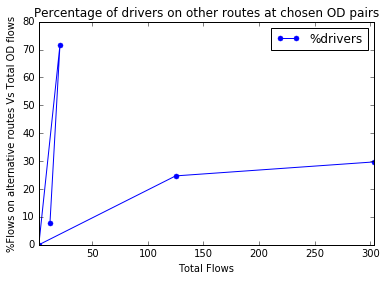

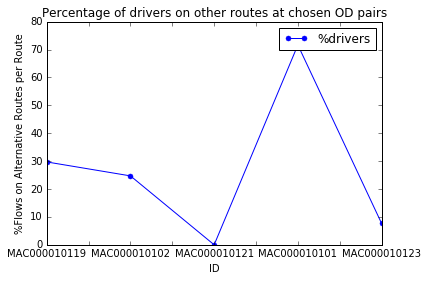

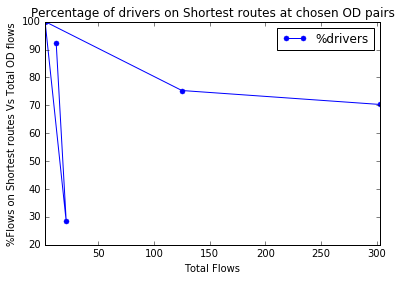

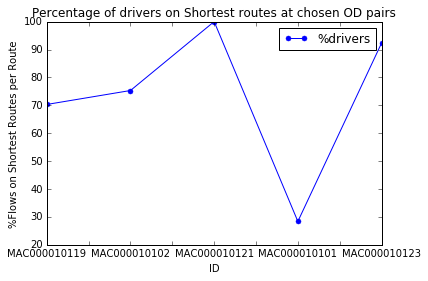

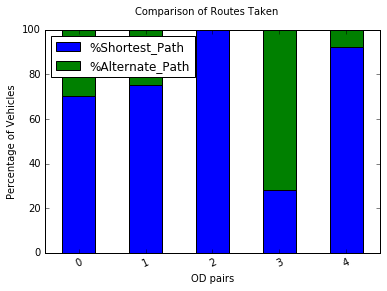

In [16]:
#Vehicles on other paths - Section 2
sql_od = "Select Origin as O, Destination as D, count as flow from Totalroutecount;"
sql_omd = "Select Origin as Om, Destination as Dm, count as flow_m from ODroutecount;"
df_od = pd.read_sql_query(sql_od,con) #df of OD flow
df_omd = pd.read_sql_query(sql_omd,con) #df for OMD flows
df_sum = df_omd.groupby("om")["flow_m"].sum().reset_index() #sum of omd route flows
merge_df = df_od.merge(df_sum, left_on= 'o', right_on = 'om', how ='outer') #merge tables
df = merge_df.drop(columns=['om'])


print (df_od)
print (df_omd)
print(df_sum)
print(merge_df)
print (df)

df["flow_alt"] = df["flow"] - df["flow_m"] #People taking other routes
df["flow_alt"] = df["flow_alt"].abs()
print(df)


#%drivers on alternative routes
df["%Alternate_Path"] = df["flow_alt"]/ df["flow"] *100
print(df)

#%drivers on shortest path

df["%Shortest_Path"] = df["flow_m"]/df["flow"] *100

#plot on Alternate Path
fig1, ax = subplots()
df.plot(ax=ax,x="flow_m", y = "%Alternate_Path",  marker =".", markersize =10, \
        title = "Percentage of drivers on other routes at chosen OD pairs")
ax.legend(["%drivers"])
ax.set_xlabel("Total Flows")
ax.set_ylabel("%Flows on alternative routes Vs Total OD flows")

print ("%Flows on Alternate rotes Vs Total Flows plotted")

#%Flows on alternative routes Vs OD
fig2, ax = subplots()
df.plot(ax=ax,x="o", y = "%Alternate_Path",  marker =".", markersize =10, \
        title = "Percentage of drivers on other routes at chosen OD pairs")
ax.legend(["%drivers"])
ax.set_xlabel("ID")
ax.set_ylabel("%Flows on Alternative Routes per Route")

#plot on Shortest Path
fig3, ax = subplots()
df.plot(ax=ax,x="flow_m", y = "%Shortest_Path",  marker =".", markersize =10, \
        title = "Percentage of drivers on Shortest routes at chosen OD pairs")
ax.legend(["%drivers"])
ax.set_xlabel("Total Flows")
ax.set_ylabel("%Flows on Shortest routes Vs Total OD flows")

print ("%Flows on Shortest Routes Vs Total Flows plotted")

#%Flows on alternative routes Vs OD
fig4, ax = subplots()
df.plot(ax=ax,x="o", y = "%Shortest_Path",  marker =".", markersize =10, \
        title = "Percentage of drivers on Shortest routes at chosen OD pairs")
ax.legend(["%drivers"])
ax.set_xlabel("ID")
ax.set_ylabel("%Flows on Shortest Routes per Route")

#Histogram with %flows on routes
from matplotlib.pyplot import hist
df_2 = pd.concat([df["%Shortest_Path"], df["%Alternate_Path"]], axis = 1, \
                 keys = ["%Shortest_Path", "%Alternate_Path"])
print (df_2)
df_2.plot(kind ='bar',stacked =True)
plt.xticks(rotation=25)
plt.suptitle ("Comparison of Routes Taken")
plt.xlabel("OD pairs")
plt.ylabel("Percentage of Vehicles")


In [ ]:
#############################End of Analysis#####################################

In [ ]:
###Except Visualisations
%matplotlib inline 
#Importing Geometries

def importRoads():     #(data has come from openstreetmap, then ogr2ogr )
    print("importing roads...")
    sql = "DROP TABLE IF EXISTS Road;"
    cur.execute(sql)
    sql = "CREATE TABLE Road (name text, geom geometry, highway text);"
    cur.execute(sql)
    fn_osm_shp = "/headless/data/dcc.osm.shp/lines.shp"
    df_roads = gpd.GeoDataFrame.from_file(fn_osm_shp)
    df_roads = df_roads.to_crs({'init': 'epsg:27700'})
    for index, row in df_roads.iterrows():
        sql="INSERT INTO Road VALUES ('%s', '%s', '%s');"\
        %(row.name, row.geometry, row.highway )
        cur.execute(sql)
    con.commit()
    print ("Roads imported")

importRoads()

##Creating list of BT sites table
def importBluetoothSites():
    print("importing sites...")
    sql = "DROP TABLE IF EXISTS BluetoothSite;"
    cur.execute(sql)
    sql = "CREATE TABLE BluetoothSite ( id serial PRIMARY KEY, siteID text,\
    geom geometry);"
    cur.execute(sql)
    con.commit()    
    fn_sites = "/headless/data/sites.csv"
    df_sites = pd.read_csv(fn_sites, header=1)   #dataframe. header is which row to use for the field names.
    for i in range(0, df_sites.shape[0]):      #munging to extract the coordinates - the arrive in National Grid
        locationstr = str(df_sites.iloc[i]['Grid'])
        bng_east  = locationstr[0:6]
        bng_north = locationstr[6:12]
        sql = "INSERT INTO BluetoothSite (siteID, geom) \
        VALUES ('%s', 'POINT(%s %s)');"%(df_sites.iloc[i]['Site ID'], \
        bng_east, bng_north )
        cur.execute(sql)
    con.commit()        
    print ("BT Sites imported")
importBluetoothSites()

def plotRoads():   
    print("plotting roads...")
    sql = "SELECT * FROM Road;"
    df_roads = gpd.GeoDataFrame.from_postgis(sql,con,geom_col='geom')
    for index, row in df_roads.iterrows():
        (xs,ys) = row['geom'].coords.xy
        color='y'
        #road colour by type
        if row['highway']=="motorway":
            color = 'b'
        if row['highway']=="trunk":
            color = 'g'
        #if not color=='y':  #only plot major roads
        plot(xs, ys, color)
    print("Roads plotted")
plotRoads()

def plotBluetoothSites():    
    sql = "SELECT siteID, geom FROM BluetoothSite;"
    df_sites = gpd.GeoDataFrame.from_postgis(sql,con,geom_col='geom') #
    for index, row in df_sites.iterrows():
        (xs,ys) = row['geom'].coords.xy
        plot(xs, ys, 'bo')
    print ("BT sites plotted")  
plotBluetoothSites()
def plotFlows(con,cur):     
    dt_start  = datetime.datetime.strptime('2015-01-05_00:00:00' , \
                                           "%Y-%m-%d_%H:%M:%S" )
    dt_end    = datetime.datetime.strptime('2016-12-10_00:00:00' , \
                                           "%Y-%m-%d_%H:%M:%S" )
    sql = "SELECT ways.gid, SUM(ODroutecount.count), ways.the_geom FROM ways,\
    ODroutecount  WHERE ODroutecount.gid::int=ways.gid AND ODroutecount.timestamp>'%s'\
    AND ODroutecount.timestamp<'%s'  GROUP BY ways.gid;"%(dt_start,dt_end)
    print(sql) 
    df_links = gpd.GeoDataFrame.from_postgis(sql,con,geom_col='the_geom')
    for i in range(0,df_links.shape[0]): 
        link = df_links.iloc[i]
        lons = link['the_geom'].coords.xy[0] #coordinates in latlon
        lats = link['the_geom'].coords.xy[1]
        gid = int(link.gid) 
        xs=[];ys=[]
        n_segments = len(lons)
        for j in range(0, n_segments):
            (x,y) = pyproj.transform(wgs84, bng, lons[j], lats[j]) #project to BNG -- uses nonISO lonlat convention  #TODO faster to cache this! 
            xs.append(x)
            ys.append(y)
        color='r'
        lw = int(link['sum']/10000)
        plot(xs, ys, color, linewidth=lw)  
plotFlows(con,cur)
print ("Flows plotted")


In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

mapbox_access_token = "pk.eyJ1Ijoic3JlZXNvbWFkYXMiLCJhIjoiY2poZXY5aDNoMDNjNDM3bnJhaXZneHF5YyJ9.5io2Q2NCWyJTE82MSK5PdA"


df = pd.read_csv("/headless/data/BTsites.csv")
print (df)
site_lat = df.Latitude
site_lon = df.Longitude
locations_name = df.Description

data = [
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=17,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        text=locations_name,
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=8,
            color='rgb(242, 177, 172)',
            opacity=0.7
        ),
        hoverinfo='none'
    )]


layout = go.Layout(
    title='Bluetooth Sites',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=38,
            lon=-94
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)

fig = dict(data=data, layout=layout)

py.iplot(fig, filename='Bluetooth Sites')
